# Задание

Выполните задания, по каждому варианту напишите точность распознавания на проверочной выборке и сделайте выводы (тексты писателей).

А. Запустите нейронку c bag of words (01) при разных maxWordsCount

1. 100

2. 1000

3. 10000

4. 50000

*Если у Вас будет переполнение ОЗУ, можно написать “не хватает памяти” в ноутбуке

Б. Запустите нейронку c bag of words (01) при maxWordsCount = 10000 и разных архитектурах

1. Поменяйте количество нейронов в слоях

2. Поменяйте количество слоев

3. Поменяйте активационные функции слоев

В. Запустите нейронку c Embbedding при maxWordsCount = 10000, поменяйте размер Embedding пространства

1. 10

2. 50

3. 200

In [ ]:
#from google.colab import files   # для работы с файлами
#from google.colab import drive   # для подключения гугл-диска
import os  # так же для файлов

import numpy as np   # для работы с данными
import pandas as pd   # для работы с таблицами
import time    # Импортируем библиотеку time

import matplotlib.pyplot as plt  # для вывода графиков обучения
# Выводить график в колабе
%matplotlib inline

from tensorflow.keras import utils  # для работы с категориальными данными
from tensorflow.keras.models import Sequential  # полносвязная модель
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation   # Слои для сети
from tensorflow.keras.preprocessing.text import Tokenizer   # Методы для работы с текстами и преоборазвания их в последовательности
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Методы для работы с последовательностями

from sklearn.preprocessing import LabelEncoder  # Метод кодирования тестовых лейблов
from sklearn.model_selection import train_test_split  # Для раздения выборки на тестовую и обучающую

# Загружаем данные и готовим их к подаче в нашу нейронную сеть

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd   
gdd.download_file_from_google_drive(file_id='1zBdThRwYeRKUG7aBlK9gtMh7aUQX6Tyr', 
                                    dest_path='/content/Тексты писателей.zip', 
                                    showsize=True,
                                    overwrite=True) #Скачиваем Тексты писателей.zip

7.8 MiB Done.


In [ ]:
!rm -R '/content/texts' # Проверяем наличие папки texts. Если есть, удаляем ее

In [ ]:
# Создаем папку texts и извлекаем туда базу
!unzip -q '/content/Тексты писателей.zip' -d '/content/texts' 

In [ ]:
def readText(fileName):         # Готовим функцию для чтения файлов
  f = open(fileName, 'r')       # Открываем файл в режиме чтения
  text = f.read()               # Читаем текст из файла
  text = text.replace('\n',' ') # Переносы строки переводим в пробелы

  return text                   # Возвращаем текст файла

In [ ]:
className = ["О. Генри", "Стругацкие", "Булгаков", "Саймак", "Фрай", "Брэдберри"]     # Объявляем интересующие нас классы
nClasses = len(className)      # Считаем количество классов

In [ ]:
# Загружаем обучающие тексты

trainText = []    # Создаём список для обучающих текстов
testText = []     # Формируем тестовые тексты

# Формирование необходимо произвести следующим образом 
# Класс каждого i-ого эллемента в обучающей выборке должен соответствовать 
# классу каждого i-ого эллемента в тестовой выборке

for class_Name_Value in className:    # Проходим по каждому классу
  for file_Name_Value in os.listdir('/content/texts/Тексты писателей/'):   # Проходим по каждому файлу
    if class_Name_Value in file_Name_Value :    # Проверяем, содержит ли название файла имя класса (фамилию автора)
      if 'Обучающая' in file_Name_Value:     # Если в имени файла есть слово "Обучающая"
        trainText.append(readText('/content/texts/Тексты писателей/'+file_Name_Value))  # Добавляем текст о обучающую выборку
        print(file_Name_Value,'добавлен в обучающую выборку')    # Выводим информацию
      if 'Тестовая' in file_Name_Value:
        testText.append(readText('/content/texts/Тексты писателей/'+file_Name_Value))   # Добавляем текст в тестовую выборку
        print(file_Name_Value,'добавлен в тестовую выборку')    # Выводим информацию

  print()      # Перенос строки делаем для удобства восприятия 

(О. Генри) Обучающая_50 вместе.txt добавлен в обучающую выборку
(О. Генри) Тестовая_20 вместе.txt добавлен в тестовую выборку

(Стругацкие) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Стругацкие) Тестовая_2 вместе.txt добавлен в тестовую выборку

(Булгаков) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Булгаков) Тестовая_2 вместе.txt добавлен в тестовую выборку

(Клиффорд_Саймак) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Клиффорд_Саймак) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Макс Фрай) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Макс Фрай) Тестовая_2 вместе.txt добавлен в тестовую выборку

(Рэй Брэдберри) Обучающая_22 вместе.txt добавлен в обучающую выборку
(Рэй Брэдберри) Тестовая_8 вместе.txt добавлен в тестовую выборку



In [ ]:
cur_time = time.time()  # Засекаем текущее время

maxWordsCount = 10000   # Определяем максимальное количество слов/индексов, учитываемое при обучении текстов

# Воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
# num_words=maxWordsCount - определяем максимальное количество слов/индексов, учитываемое при обучении текстов
# filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' - избавляемся от ненужных символов
# lower=True - приводим слова к нижнему регистру
# split=' ' - разделяем слова по пробелу
# char_level=False - токенизируем по словам (Если будет True - каждый символ будет рассматриваться как отдельный токен )
tokenizer = Tokenizer(num_words=maxWordsCount, 
                      filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', 
                      lower=True, 
                      split=' ', 
                      oov_token='unknown', 
                      char_level=False)

tokenizer.fit_on_texts(trainText) # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности

items = list(tokenizer.word_index.items()) # Вытаскиваем индексы слов для просмотра
print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

Время обработки: 2.89c


In [ ]:
 items[:30]   # Смотрим здесь словарь частотности

[('unknown', 1),
 ('и', 2),
 ('в', 3),
 ('не', 4),
 ('я', 5),
 ('что', 6),
 ('на', 7),
 ('с', 8),
 ('он', 9),
 ('а', 10),
 ('как', 11),
 ('то', 12),
 ('это', 13),
 ('но', 14),
 ('все', 15),
 ('у', 16),
 ('по', 17),
 ('его', 18),
 ('к', 19),
 ('так', 20),
 ('мне', 21),
 ('из', 22),
 ('за', 23),
 ('меня', 24),
 ('ты', 25),
 ('же', 26),
 ('бы', 27),
 ('сказал', 28),
 ('вы', 29),
 ('было', 30)]

In [ ]:
# Преобразовываем текст в последовательность индексов согласно частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences(trainText) # Переводим обучающие тесты в индексы
testWordIndexes = tokenizer.texts_to_sequences(testText)  # Переводим проверочные тесты в индексы

In [ ]:
# Осматриваем результаты полученных промежуточных преоборазовании

print("Взглянем на фрагмент обучающего текста:")
print("В виде оригинального текста:              ", trainText[1][:87])
print("Он же в виде последовательности индексов: ", trainWordIndexes[1][:20], '\n')

Взглянем на фрагмент обучающего текста:
В виде оригинального текста:               Парень из преисподней     1     Ну и деревня! Сроду я таких деревень не видел и не знал
Он же в виде последовательности индексов:  [473, 22, 1, 1508, 47, 2, 1, 7800, 5, 415, 1, 4, 251, 2, 4, 249, 55, 6, 240, 9472] 



In [ ]:
# Смотрим статистику по объемам обучающей выборки, чтобы оценить, на сколько у нас сбалансирована база

print("Статистика по обучающим текстам:\n")

symbolsTrainText = 0 # Объявляем переменную для подсчета символов в обучающих текстах
wordsTrainText = 0 # Объявляем переменную для подсчета слов в обучающих текстах

for i in range(nClasses): # Проходим по всем классам
  print(className[i], " "*(10-len(className[i])), len(trainText[i]), "символов, ", len(trainWordIndexes[i]), "слов")
  symbolsTrainText += len(trainText[i]) # Считаем символы
  wordsTrainText += len(trainWordIndexes[i]) # Считаем слова 

print('-------------------------------------------')
print("В сумме ", symbolsTrainText, " символов, ", wordsTrainText, " слов \n")
print()
print("Статистика по тестовым текстам:\n")

symbolsTestText = 0 # Объявляем переменную для подсчета символов в тестовых текстах
wordsTestText = 0 # Объявляем переменную для подсчета слов в тестовых текстах

for i in range(nClasses): #Проходим по всем классам
  print(className[i], ' '*(10-len(className[i])), len(testText[i]), "символов, ", len(testWordIndexes[i]), "слов")
  symbolsTestText += len(testText[i]) #Считаем символы
  wordsTestText += len(testWordIndexes[i]) #Считаем слова 

print('-------------------------------------------')
print("В сумме ", symbolsTestText, " символов, ", wordsTestText, " слов")

Статистика по обучающим текстам:

О. Генри    1049517 символов,  160607 слов
Стругацкие  2042469 символов,  313012 слов
Булгаков    1765648 символов,  261465 слов
Саймак      1609507 символов,  251502 слов
Фрай        3700010 символов,  568533 слов
Брэдберри   1386454 символов,  214454 слов
-------------------------------------------
В сумме  11553605  символов,  1769573  слов 


Статистика по тестовым текстам:

О. Генри    349662 символов,  53238 слов
Стругацкие  704846 символов,  108621 слов
Булгаков    875042 символов,  132730 слов
Саймак      318811 символов,  50360 слов
Фрай        1278191 символов,  196731 слов
Брэдберри   868673 символов,  132524 слов
-------------------------------------------
В сумме  4395225  символов,  674204  слов


In [ ]:
# Формирование обучающей выборки по листу индексов слов  (разделение на короткие векторы)

def getSetFromIndexes(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна
  xSample = [] # Объявляем переменную для векторов
  wordsLen = len(wordIndexes) # Считаем количество слов
  index = 0 # Задаем начальный индекс 

  while (index + xLen) <= wordsLen :# Идём по всей длине вектора индексов
    xSample.append(wordIndexes[index:index+xLen]) # "Откусываем" векторы длины xLen
    index += step # Смещаеммся вперёд на step
    
  return xSample

In [ ]:
# Формирование обучающей и проверочной выборки
# Из двух листов индексов от двух классов

def createSetsMultiClasses(wordIndexes, xLen, step): # Функция принимает последовательность индексов, размер окна, шаг окна

  # Для каждого из 6 классов
  # Создаём обучающую/проверочную выборку из индексов
  nClasses = len(wordIndexes) # Задаем количество классов выборки
  classesXSamples = []        # Здесь будет список размером "кол-во классов*кол-во окон в тексте*длину окна (например, 6 по 1341*1000)"
  for wI in wordIndexes:      # Для каждого текста выборки из последовательности индексов
    classesXSamples.append(getSetFromIndexes(wI, xLen, step)) # Добавляем в список очередной текст индексов, разбитый на "кол-во окон*длину окна" 


  # Формируем один общий векторов для обучения в xSamples и соответствующие ответы для них в ySamples (то есть какого писателя эта последовательность)

  xSamples = [] # Здесь будет список размером "суммарное кол-во окон во всех текстах*длину окна (например, 15779*1000)"
  ySamples = [] # Здесь будет список размером "суммарное кол-во окон во всех текстах*вектор длиной 6"
  
  for t in range(nClasses): # В диапазоне кол-ва классов(6)
    xT = classesXSamples[t] # Берем очередной текст вида "кол-во окон в тексте*длину окна"(например, 1341*1000)
    for i in range(len(xT)): # И каждое его окно
      xSamples.append(xT[i]) # Добавляем в общий список выборки
      ySamples.append(utils.to_categorical(t, nClasses)) # Добавляем соответствующий вектор класса

  xSamples = np.array(xSamples) # Переводим в массив numpy для подачи в нейронку
  ySamples = np.array(ySamples) # Переводим в массив numpy для подачи в нейронку

  
  return (xSamples, ySamples) #Функция возвращает выборку и соответствующие векторы классов. ySample уже в формате One Hot Encoding

In [ ]:
#Задаём базовые параметры
xLen = 1000 #Длина отрезка текста, по которой анализируем, в словах
step = 100 #Шаг разбиения исходного текста на обучающие векторы

In [ ]:
cur_time = time.time() # Засекаем текущее время

#Формируем обучающую и тестовую выборку
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) #извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    #извлекаем тестовую выборку

print(xTrain.shape)
print(yTrain.shape)

print(xTest.shape)
print(yTest.shape)

#получили обучающий/тестовый набор, достаточный для запуска Embedding, но для Bag of Words нужно xTrain и xTest представить в виде векторов из 0 и 1
print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

(17640, 1000)
(17640, 6)
(6686, 1000)
(6686, 6)
Время обработки: 2.43c


In [ ]:
cur_time = time.time() # Засекаем текущее время
# Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist()) #Подаем xTrain в виде списка, чтобы метод успешно сработал
xTest01 = tokenizer.sequences_to_matrix(xTest.tolist()) # Подаем xTest в виде списка, чтобы метод успешно сработал

print(xTrain01.shape)       # Размер обучающей выборки, сформированной по Bag of Words
print(xTrain01[23][0:50]) # Фрагмент набора слов в виде Bag of Words
print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

(17640, 10000)
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0.
 0. 0.]
Время обработки: 11.81c


# Создаём сеть с базовыми показателями с занятия и запускаем её

Epoch 1/10
138/138 [==============================] - 2s 10ms/step - loss: 0.0619 - accuracy: 0.9809 - val_loss: 0.4424 - val_accuracy: 0.8700
Epoch 2/10
138/138 [==============================] - 1s 10ms/step - loss: 6.6930e-04 - accuracy: 1.0000 - val_loss: 0.3964 - val_accuracy: 0.8663
Epoch 3/10
138/138 [==============================] - 1s 10ms/step - loss: 3.3131e-04 - accuracy: 1.0000 - val_loss: 0.3843 - val_accuracy: 0.8688
Epoch 4/10
138/138 [==============================] - 1s 10ms/step - loss: 2.0001e-04 - accuracy: 1.0000 - val_loss: 0.3752 - val_accuracy: 0.8709
Epoch 5/10
138/138 [==============================] - 1s 10ms/step - loss: 1.3850e-04 - accuracy: 1.0000 - val_loss: 0.3669 - val_accuracy: 0.8730
Epoch 6/10
138/138 [==============================] - 1s 10ms/step - loss: 1.0220e-04 - accuracy: 1.0000 - val_loss: 0.3667 - val_accuracy: 0.8720
Epoch 7/10
138/138 [==============================] - 1s 10ms/step - loss: 8.1443e-05 - accuracy: 1.0000 - val_loss: 0.364

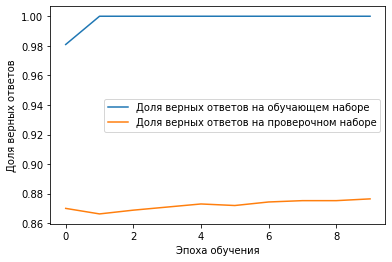

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               2000200   
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 200)               800       
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1206      
Total params: 2,002,206
Trainable params: 2,001,806
Non-trainable params: 400
_________________________________________________________________


In [ ]:
#Создаём полносвязную сеть
model01 = Sequential()
#Первый полносвязный слой
model01.add(Dense(200, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model01.add(Dropout(0.25))
#Слой пакетной нормализации
model01.add(BatchNormalization())
#Выходной полносвязный слой
model01.add(Dense(6, activation='sigmoid'))


model01.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model01.fit(xTrain01, 
                      yTrain, 
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest01, yTest))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

model01.summary()

# Тестирование нейронки

In [ ]:
# Представляем тестовую выборку в удобных для распознавания размерах
def createTestMultiClasses(wordIndexes, xLen, step): #функция принимает последовательность индексов, размер окна, шаг окна

  #Для каждого из 6 классов
  #Создаём тестовую выборку из индексов
  nClasses = len(wordIndexes) #Задаем количество классов
  xTest6Classes01 = []               #Здесь будет список из всех классов, каждый размером "кол-во окон в тексте * 20000 (при maxWordsCount=20000)"
  xTest6Classes = []                 #Здесь будет список массивов, каждый размером "кол-во окон в тексте * длину окна"(6 по 420*1000)
  for wI in wordIndexes:                       #Для каждого тестового текста из последовательности индексов
    sample = (getSetFromIndexes(wI, xLen, step)) #Тестовая выборка размером "кол-во окон*длину окна"(например, 420*1000)
    xTest6Classes.append(sample)              # Добавляем в список
    xTest6Classes01.append(tokenizer.sequences_to_matrix(sample)) #Трансформируется в Bag of Words в виде "кол-во окон в тексте * 20000"
  xTest6Classes01 = np.array(xTest6Classes01)                     #И добавляется к нашему списку, 
  xTest6Classes = np.array(xTest6Classes)                     #И добавляется к нашему списку, 
  
  return xTest6Classes01, xTest6Classes  #функция вернёт тестовые данные: TestBag 6 классов на n*20000 и xTestEm 6 по n*1000

# Распознаём тестовую выборку и выводим результаты
def recognizeMultiClass(model, xTest, modelName):
  print("НЕЙРОНКА: ", modelName)
  print()
  
  totalSumRec = 0 # Сумма всех правильных ответов
  
  #Проходим по всем классам
  for i in range(nClasses):
    #Получаем результаты распознавания класса по блокам слов длины xLen
    currPred = model.predict(xTest[i])
    #Определяем номер распознанного класса для каждохо блока слов длины xLen
    currOut = np.argmax(currPred, axis=1)

    evVal = []
    for j in range(nClasses):
      evVal.append(len(currOut[currOut==j])/len(xTest[i]))

    totalSumRec += len(currOut[currOut==i])
    recognizedClass = np.argmax(evVal) #Определяем, какой класс в итоге за какой был распознан
    
    #Выводим результаты распознавания по текущему классу
    isRecognized = "Это НЕПРАВИЛЬНЫЙ ответ!"
    if (recognizedClass == i):
      isRecognized = "Это ПРАВИЛЬНЫЙ ответ!"
    str1 = 'Класс: ' + className[i] + " " * (11 - len(className[i])) + str(int(100*evVal[i])) + "% сеть отнесла к классу " + className[recognizedClass]
    print(str1, " " * (55-len(str1)), isRecognized, sep='')
  
  #Выводим средний процент распознавания по всем классам вместе
  print()
  sumCount = 0
  for i in range(nClasses):
    sumCount += len(xTest[i])
  print("Средний процент распознавания ", int(100*totalSumRec/sumCount), "%", sep='')

  print()
  
  return totalSumRec/sumCount

In [ ]:
xTest6Classes01, x2 = createTestMultiClasses(testWordIndexes, xLen, step) #Преобразование тестовой выборки

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [ ]:
#Проверяем точность нейронки обученной на bag of words
pred = recognizeMultiClass(model01, xTest6Classes01, "Тексты 01 + Embedding + Dense")

НЕЙРОНКА:  Тексты 01 + Embedding + Dense

Класс: О. Генри   96% сеть отнесла к классу О. Генри   Это ПРАВИЛЬНЫЙ ответ!
Класс: Стругацкие 81% сеть отнесла к классу Стругацкие Это ПРАВИЛЬНЫЙ ответ!
Класс: Булгаков   77% сеть отнесла к классу Булгаков   Это ПРАВИЛЬНЫЙ ответ!
Класс: Саймак     79% сеть отнесла к классу Саймак     Это ПРАВИЛЬНЫЙ ответ!
Класс: Фрай       91% сеть отнесла к классу Фрай       Это ПРАВИЛЬНЫЙ ответ!
Класс: Брэдберри  96% сеть отнесла к классу Брэдберри  Это ПРАВИЛЬНЫЙ ответ!

Средний процент распознавания 87%



# Задание А

Запустите нейронку c bag of words (01) при разных maxWordsCount

1. 100

2. 1000

3. 10000

4. 50000

*Если у Вас будет переполнение ОЗУ, можно написать “не хватает памяти” в ноутбуке

## Результыты нейронки с bag of words при maxWordCount = 20000

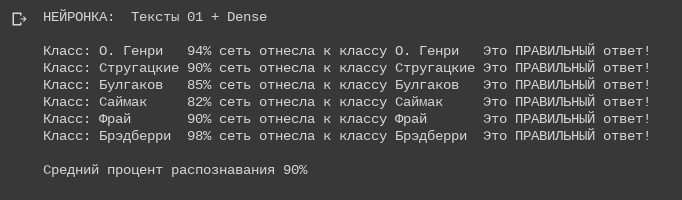

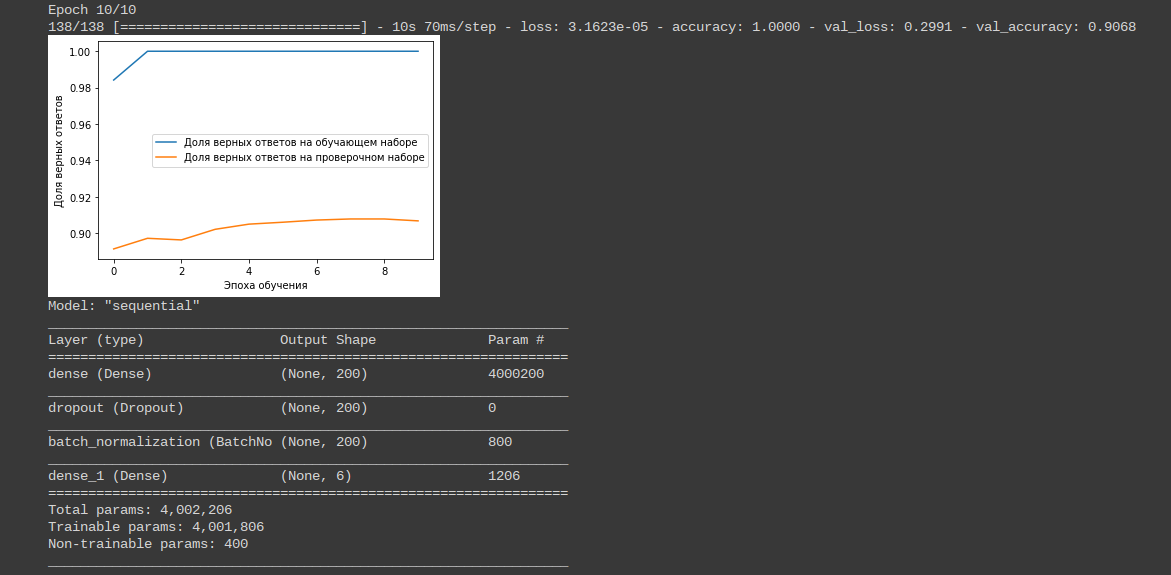


---

## Результыты нейронки с bag of words при maxWordCount = 100

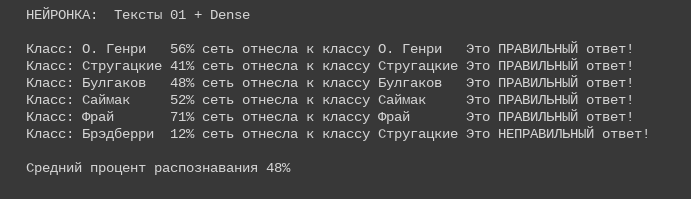

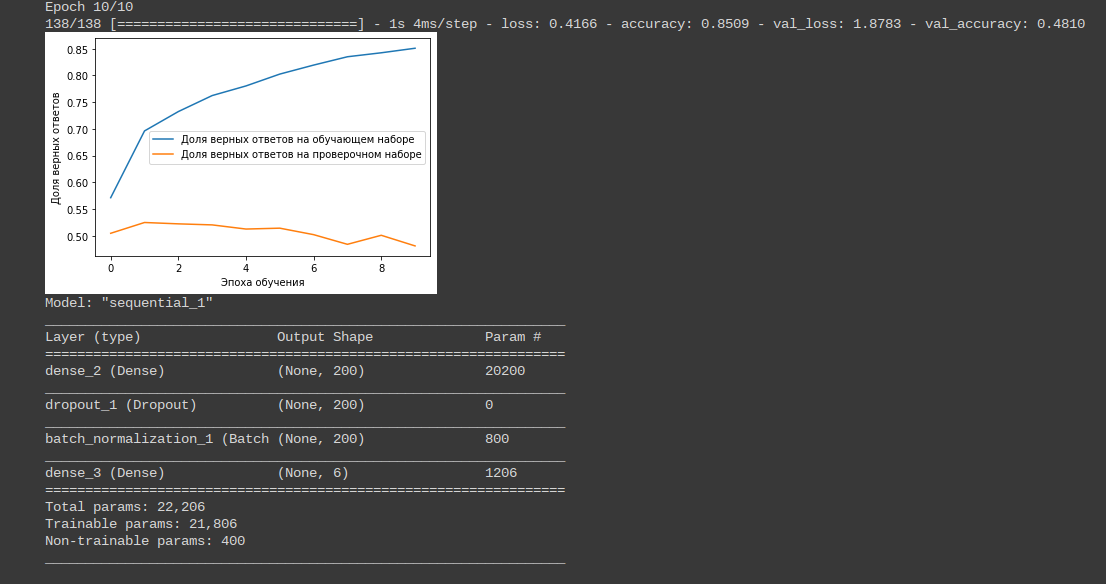


---

## Результыты нейронки с bag of words при maxWordCount = 1000

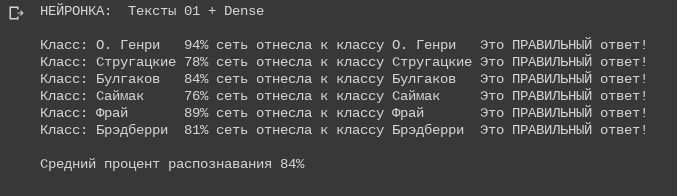

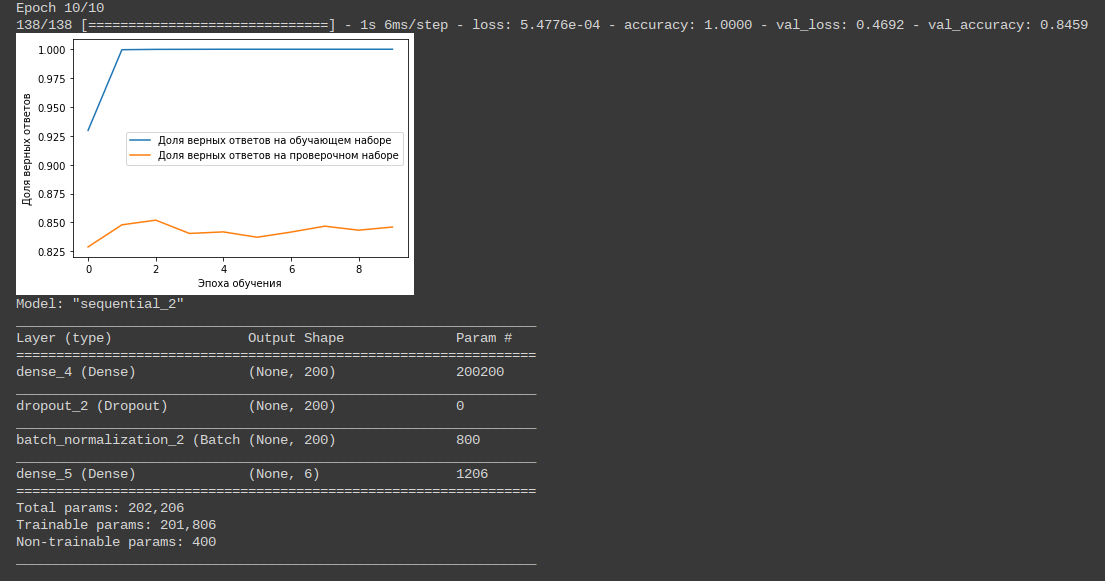

---

## Результыты нейронки с bag of words при maxWordCount = 10000

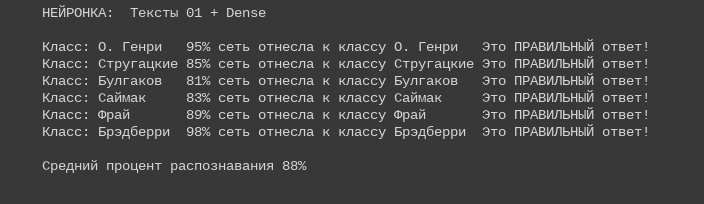

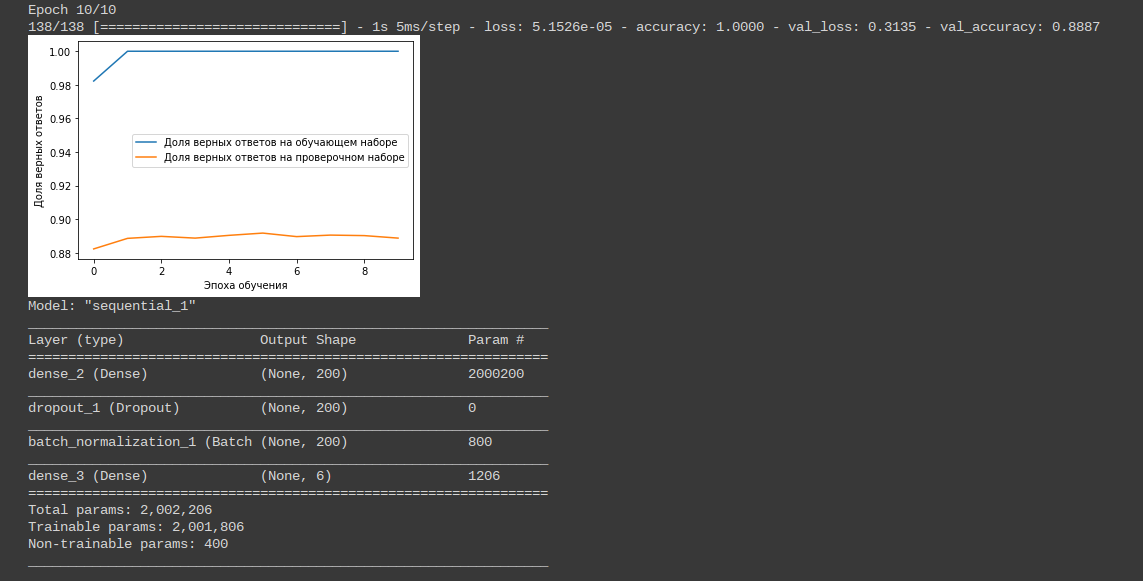

---

## Результыты нейронки с bag of words при maxWordCount = 50000

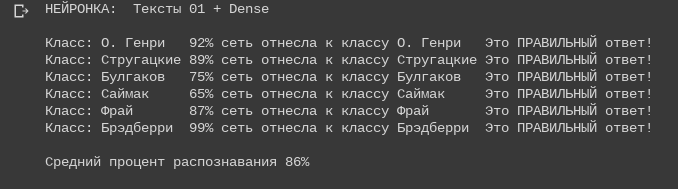

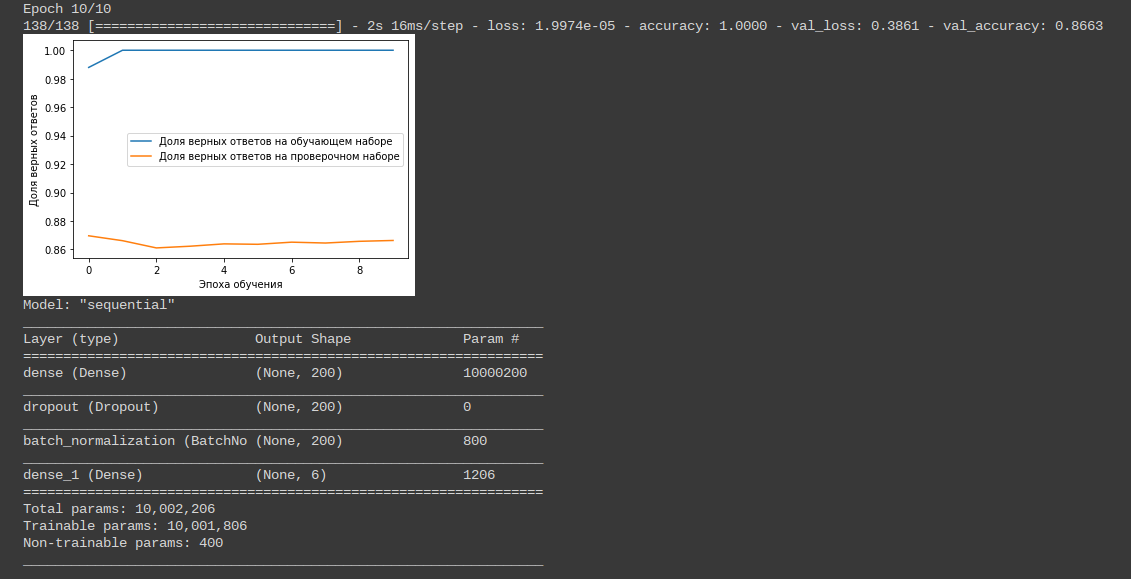

---

---
---
---

# Задание Б

Запустите нейронку c bag of words (01) при maxWordsCount = 10000 и разных архитектурах

1. Поменяйте количество нейронов в слоях

2. Поменяйте количество слоев

3. Поменяйте активационные функции слоев

## Результативность исходной версии нейронки

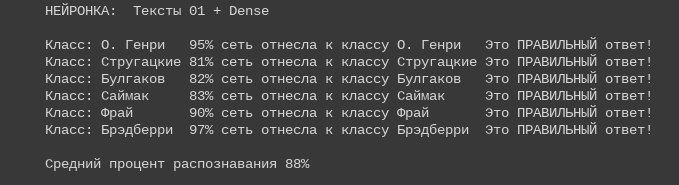

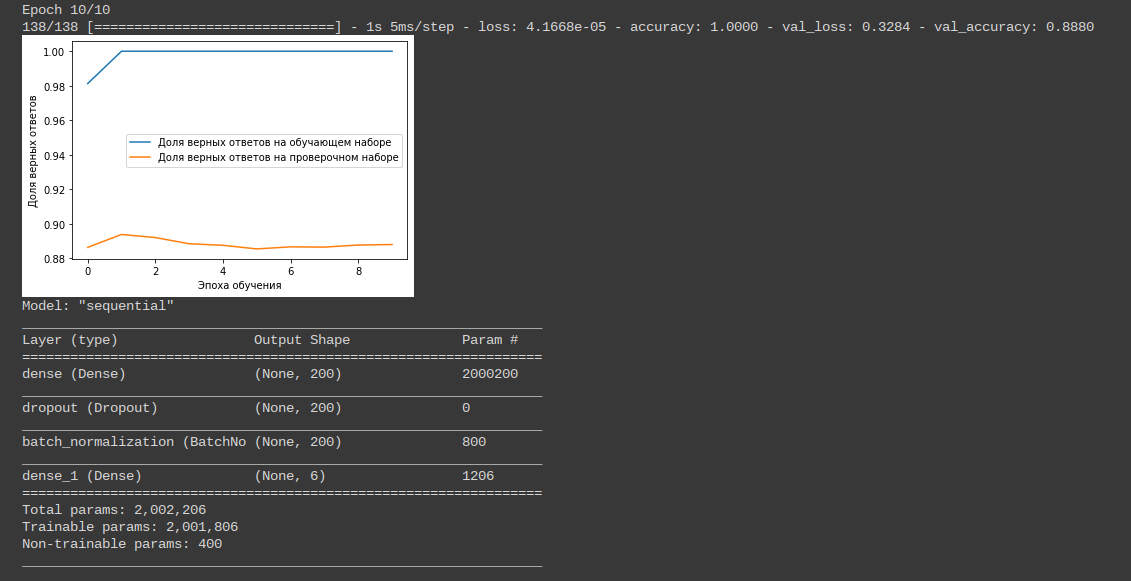

---

## Эксперимент 1. Меняем количество нейронов в слоях.

### Увеличиваем слой Dense до 400 нейронов

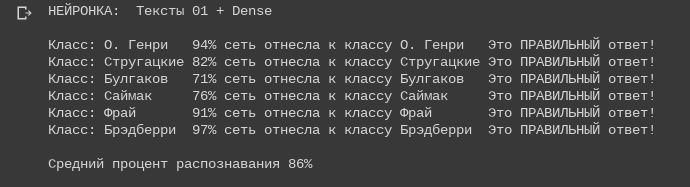

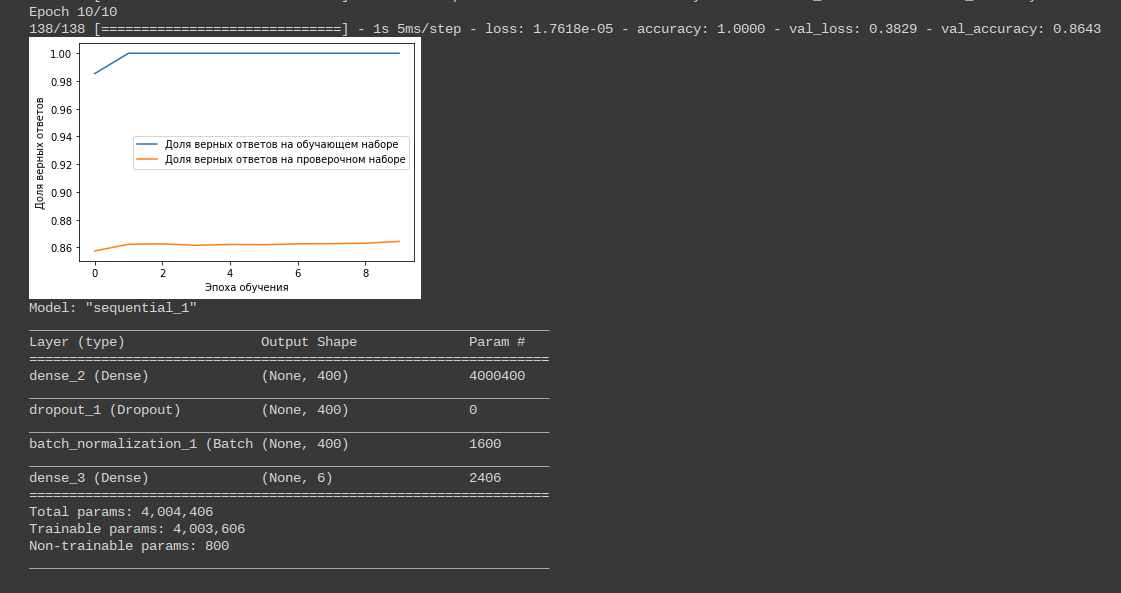

---

### Уменьшаем количество нейронов до 100

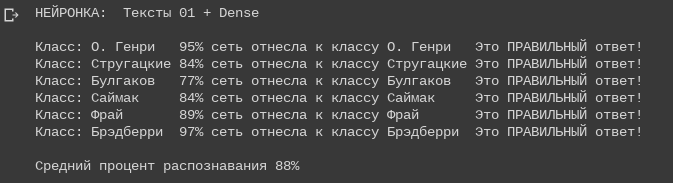

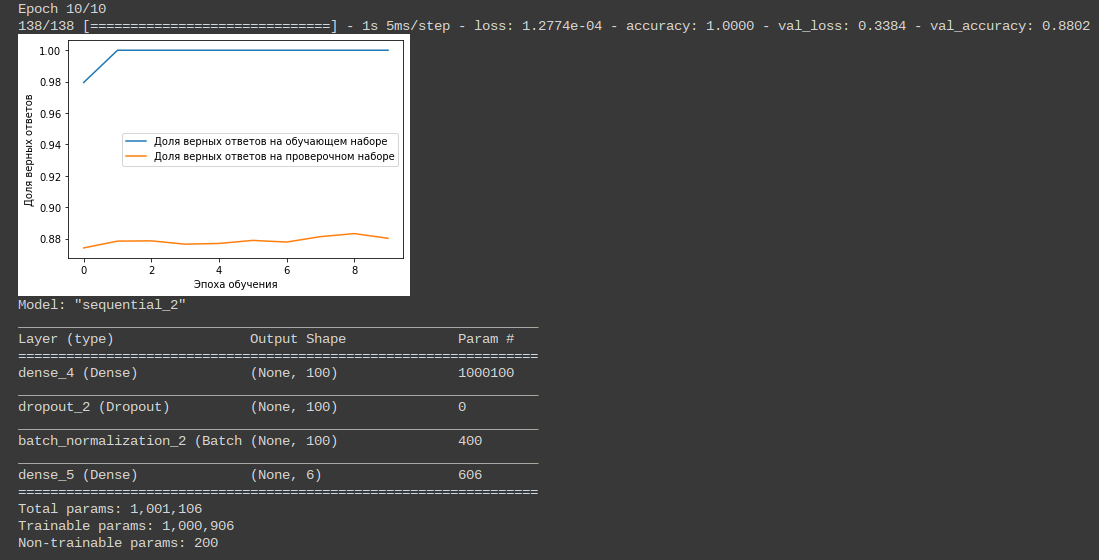


---

## Эксперимент 2. Меняем количество слоёв 

Добвляем ещё один Danse слой и слой Dropout.


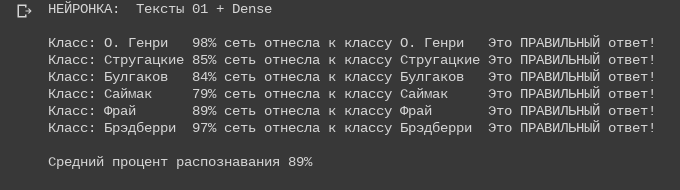

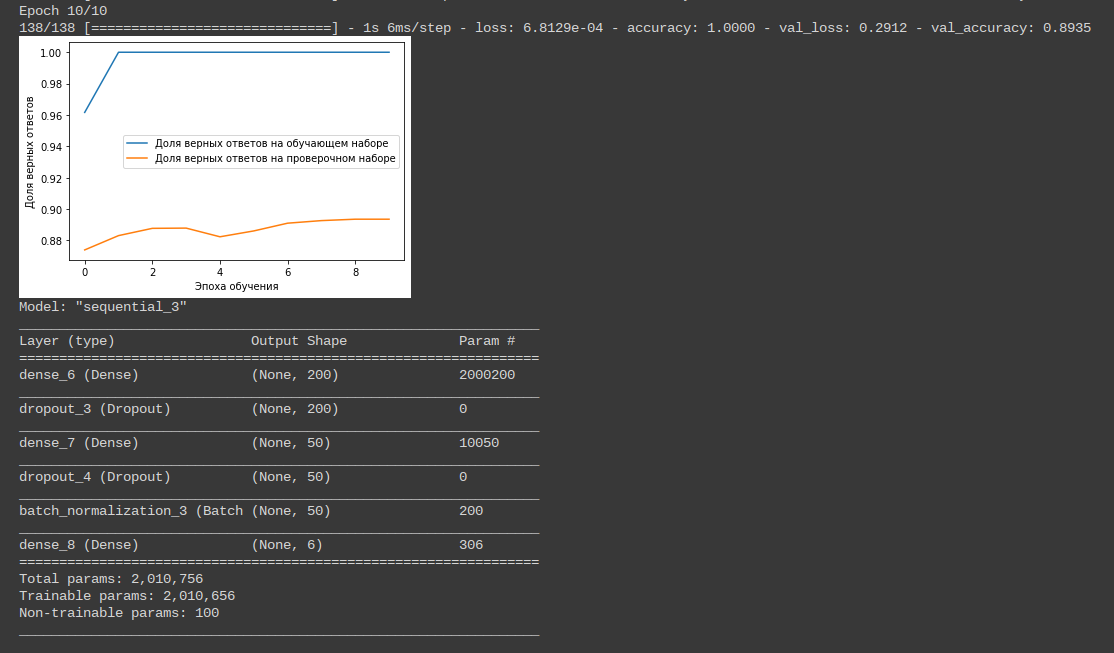

----

## Эксперимент 3. Меняем активационные функции слоёв.

### Замена активационной функции первого слоя с relu на linear никак не повлияло на точность сети.

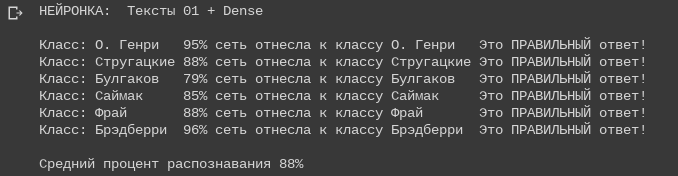

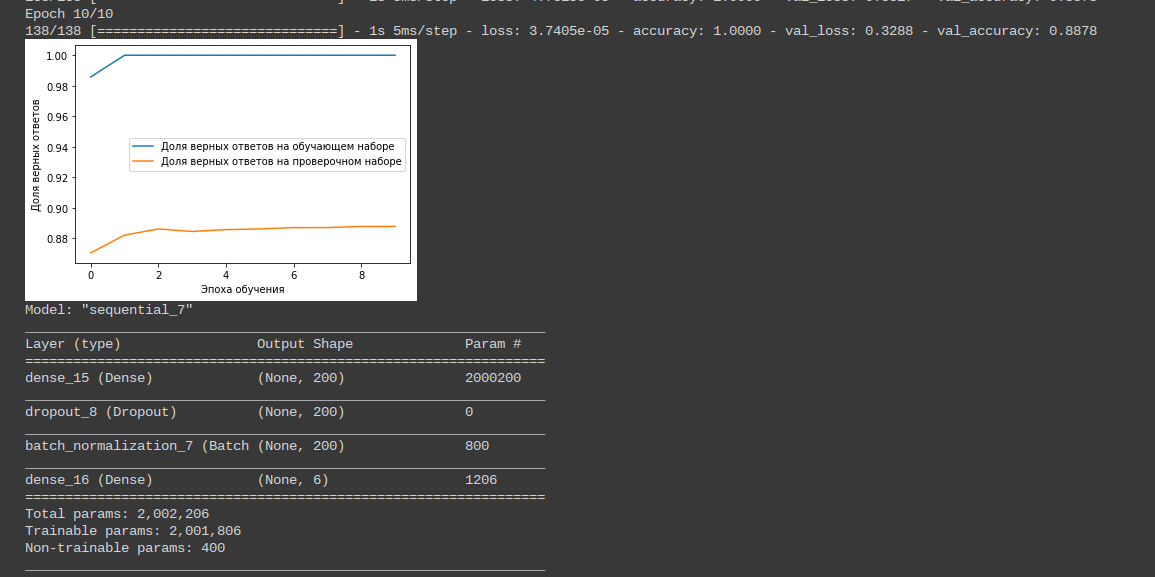

Замена активационной функции первого слоя Dense с relu на sigmoid повысило точность рапознавания с 88 до 90%

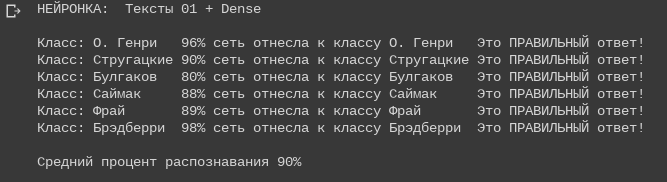

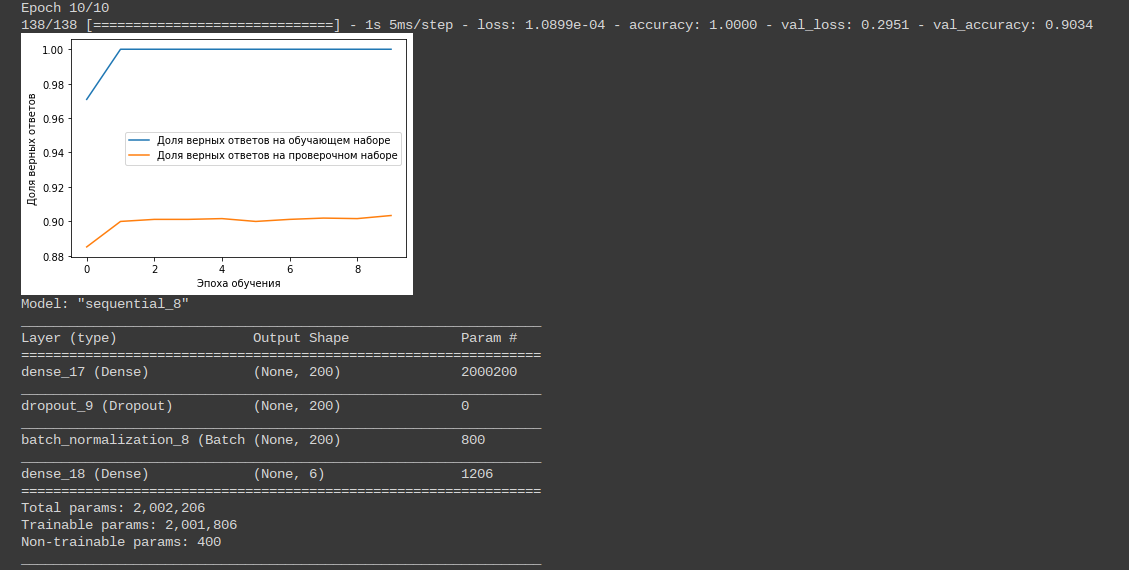

---

# Задание В

Запустите нейронку c Embbedding при maxWordsCount = 10000, поменяйте размер Embedding пространства

1. 10

2. 50

3. 200



In [ ]:
#Создаём сеть с Embedding слоем
modelE = Sequential()
modelE.add(Embedding(maxWordsCount, 100, input_length=xLen))
modelE.add(SpatialDropout1D(0.3))
modelE.add(Flatten())
modelE.add(BatchNormalization())
modelE.add(Dense(200, activation="relu"))
modelE.add(Dropout(0.3))
modelE.add(BatchNormalization())
modelE.add(Dense(6, activation='sigmoid'))

modelE.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


Epoch 1/10
138/138 [==============================] - 15s 102ms/step - loss: 0.7458 - accuracy: 0.7829 - val_loss: 1.8368 - val_accuracy: 0.3844
Epoch 2/10
138/138 [==============================] - 14s 102ms/step - loss: 0.0137 - accuracy: 0.9999 - val_loss: 1.5544 - val_accuracy: 0.3448
Epoch 3/10
138/138 [==============================] - 14s 104ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 1.1819 - val_accuracy: 0.5048
Epoch 4/10
138/138 [==============================] - 14s 102ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.8408 - val_accuracy: 0.7048
Epoch 5/10
138/138 [==============================] - 14s 102ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.7369 - val_accuracy: 0.7505
Epoch 6/10
138/138 [==============================] - 14s 104ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.7373 - val_accuracy: 0.7517
Epoch 7/10
138/138 [==============================] - 15s 107ms/step - loss: 9.9307e-04 - accuracy: 1.0000 - val_loss: 0.7403 - va

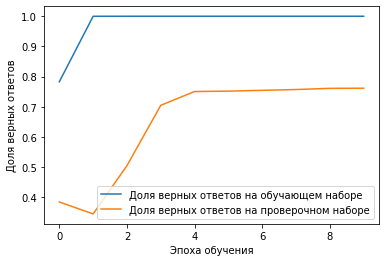

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 100)         1000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 1000, 100)         0         
_________________________________________________________________
flatten (Flatten)            (None, 100000)            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 100000)            400000    
_________________________________________________________________
dense_2 (Dense)              (None, 200)               20000200  
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 200)              

In [ ]:

#Обучаем сеть на xTrain
history = modelE.fit(xTrain, 
                    yTrain, 
                    epochs=10,
                    batch_size=128,
                    validation_data=(xTest, yTest))


plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

modelE.summary()    # Выводим структуру модели

In [ ]:
# Тест нейронки с Embedding слоем

_, xTest6Classes = createTestMultiClasses(testWordIndexes, xLen, step)   #Преобразование тестовой выборки
pred = recognizeMultiClass(modelE, xTest6Classes, "Embedding + Dense")    #Проверяем результаты работы Ebedding сети 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


НЕЙРОНКА:  Embedding + Dense

Класс: О. Генри   86% сеть отнесла к классу О. Генри   Это ПРАВИЛЬНЫЙ ответ!
Класс: Стругацкие 69% сеть отнесла к классу Стругацкие Это ПРАВИЛЬНЫЙ ответ!
Класс: Булгаков   65% сеть отнесла к классу Булгаков   Это ПРАВИЛЬНЫЙ ответ!
Класс: Саймак     70% сеть отнесла к классу Саймак     Это ПРАВИЛЬНЫЙ ответ!
Класс: Фрай       85% сеть отнесла к классу Фрай       Это ПРАВИЛЬНЫЙ ответ!
Класс: Брэдберри  75% сеть отнесла к классу Брэдберри  Это ПРАВИЛЬНЫЙ ответ!

Средний процент распознавания 76%



## Результаты нейронки с Embedding слоем размером 10

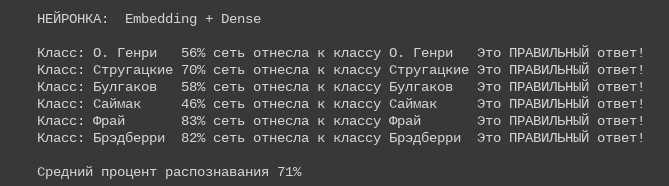

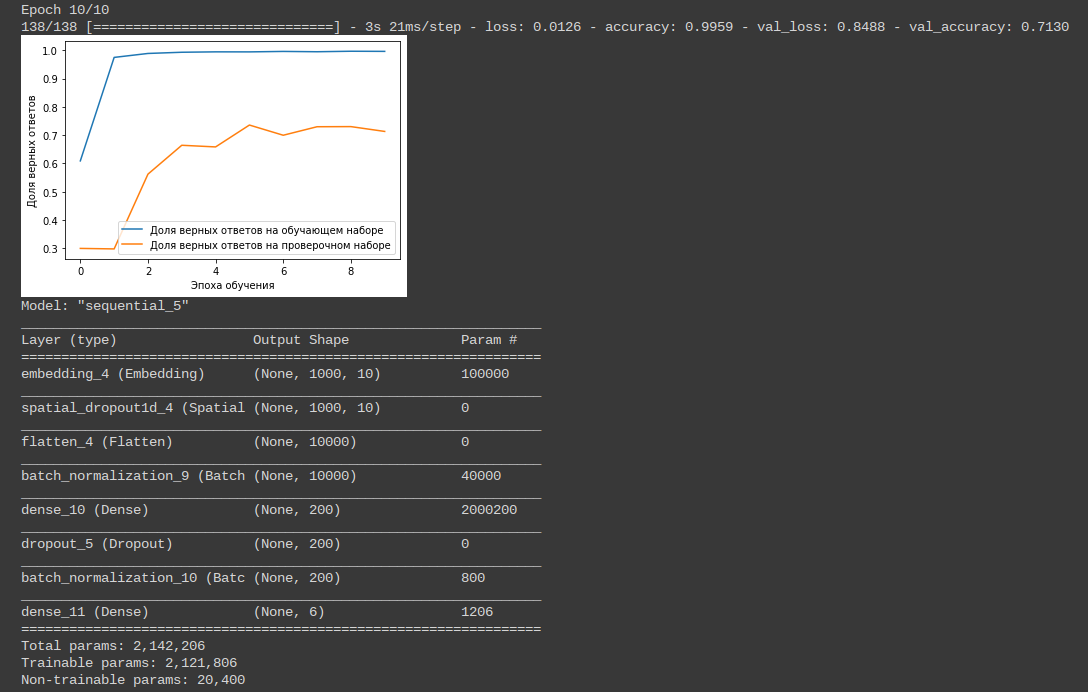

---

## Результаты нейронки с Embedding слоем размером 20

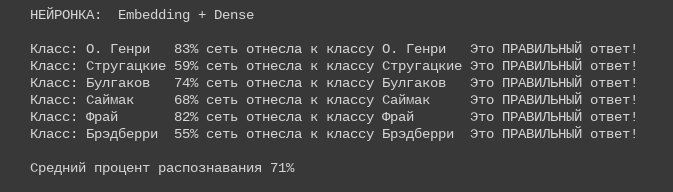

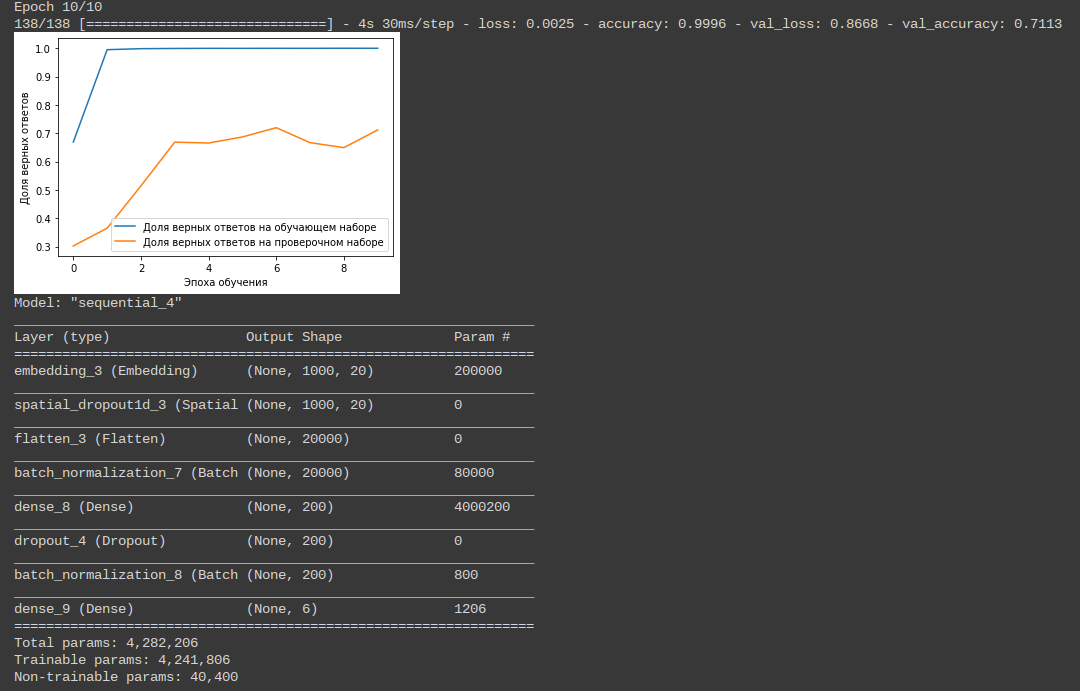

---

## Результаты нейронки с Embedding слоем размером 50

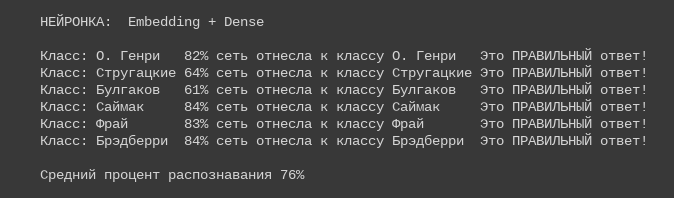

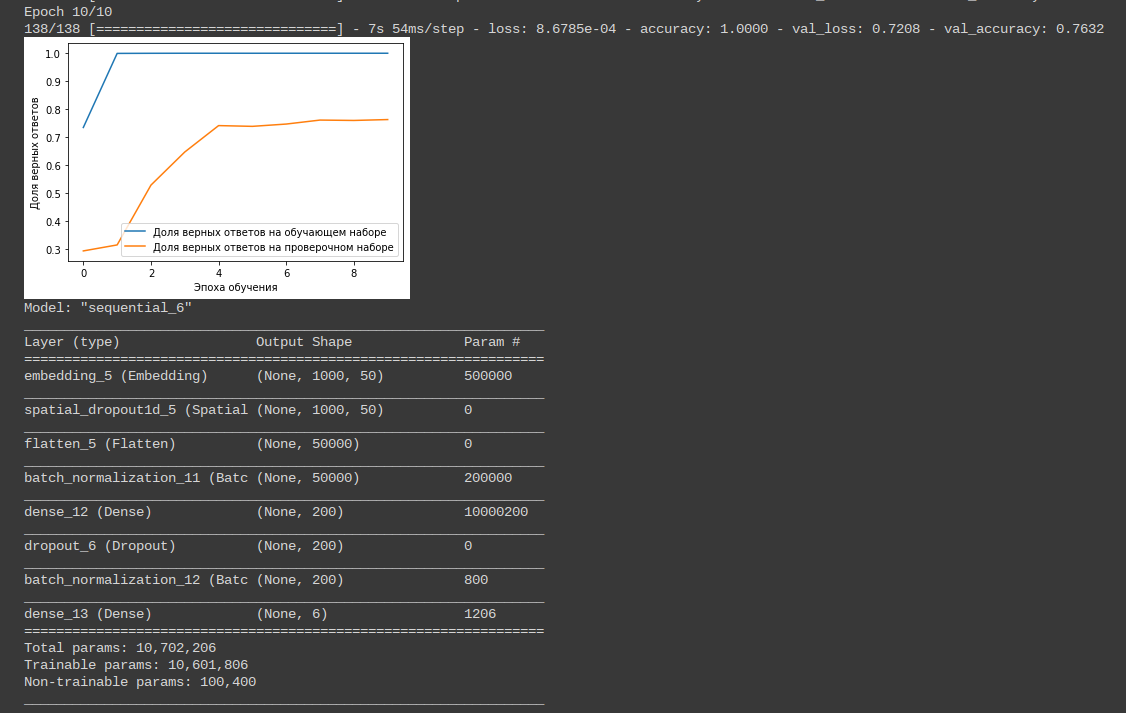

---

## Результаты нейронки с Embedding слоем размером 100

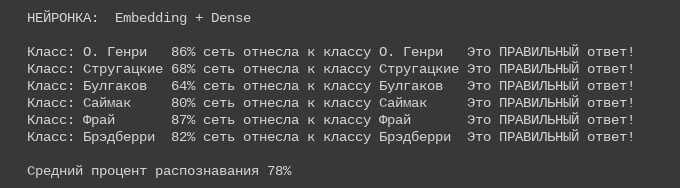

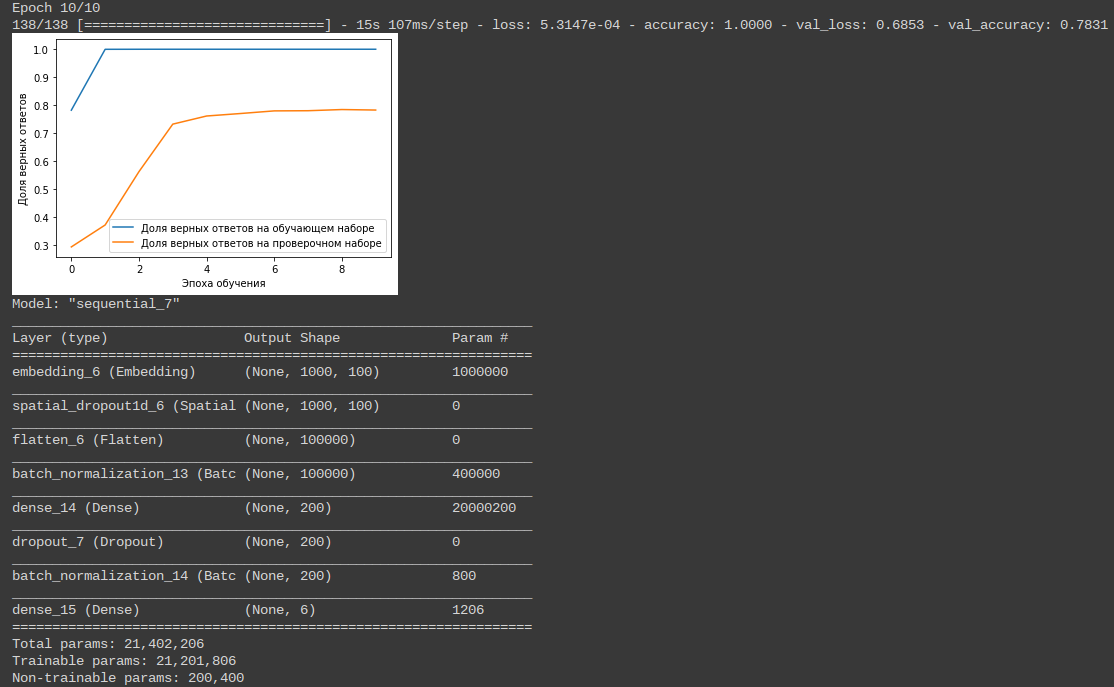
---

## Результаты нейронки с Embedding слоем размером 200

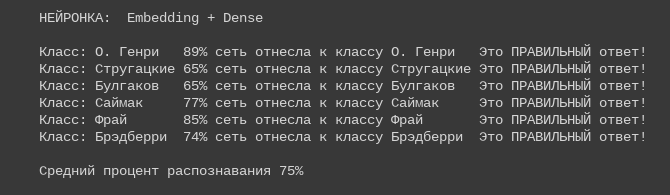

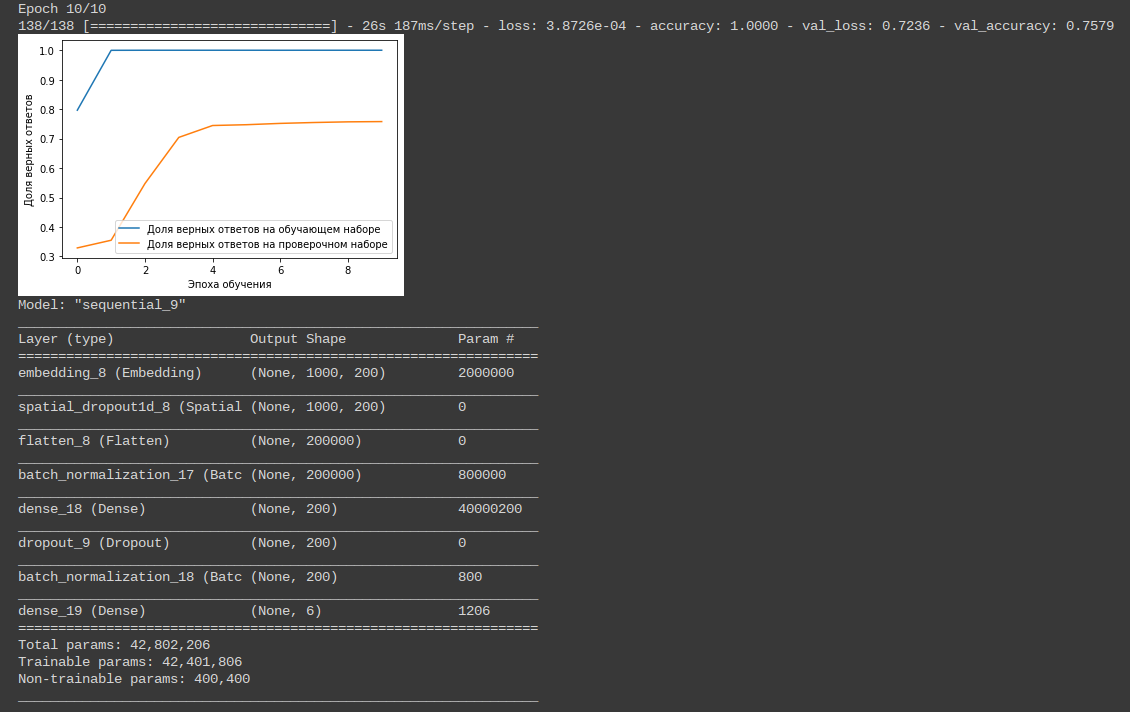

---

# Выводы








## По Заданию А

Из заданных показателей maxWordCount наилучшая показатель распознавания 90% был получен при maxWordCount = 20000

При maxWordCount = 100 точность распознавания фатально падала до 48%.

При при maxWordCount = 1000 точность поднялась до 84%
а при maxWordCount = 10000 и 50000 точность равнялась 88% и 86% соответственно.

Вывод: Пик результативности при maxWordCount = 20000 
приемлемвая результаативность при maxWordCount более 1000
при дальнейшем возратании maxWordCount более 20000 точность распознавания текстов начинает постепенно снижатся, а количество требуемой памяти для решения этой задачи существенно повышается.

## По Заданию Б

### Эксперимент 1

Уменьшение количества нейронов слоя Dense до 100 имело такую же точность как и при 200 нейронах: 88%.

Увеличение количества нейронов слоя Dense до 400 понизило точность распознавания до 86%

### Эксперимент 2

Добавив к исходной нейронке дополнительный слой Dense в 50 нейронов и слой Dropout получили улучшений качества распознавания автора на 1% (с 88 до 89%).

### Эксперимент 3

Замена активационной функции первого слоя Danse c "relu" на "linear" никак не повлияла на точност распознавания, а вот замена её же на функцию "sigmoid" повысило точность распознвания на 2%.

## По Заданию В

Точность нейронки в зависимости от размера Embedding слоя:

Embedding  10    Точность 71%

Embedding  20    Точность 71%

Embedding  50    Точность 76%

Embedding 100    Точность 78%

Embedding 200    Точность 75%

Сеть с Embedding слоем показывает худший результат, чем просто сеть из Dense слоёв.
C ростом размера Embedding слоя до 100 -- покзатели точности сети по немножку улучшаются, а далее по немножку начинают снижаться.